# Error Estimation

In this notebook, we will implement and test **error estimation approaches** for evaluating classifiers and/or learning algorithms.

At the start, we will implement the $k$-fold cross-validation with and without stratification.

Subsequently, we will use the nested $k$-fold cross-validation on an exemplary dataset to perform model selection.

### **Table of Contents**
1. [$k$-fold Cross-alidation](#k-fold-cross-validation)
2. [Model Selection](#model-selection)

In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### **1. $k$-fold Cross-validation** <a class="anchor" id="k-fold-cross-validation"></a>

We implement the function [`cross_validation`](../e2ml/evaluation/_error_estimation.py) in the [`e2ml.evaluation`](../e2ml/evaluation) subpackage. Once, the implementation has been completed, we visualize and compare the standard and stratified cross-validation.

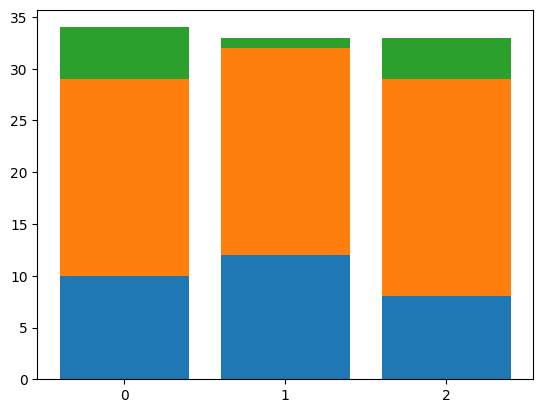

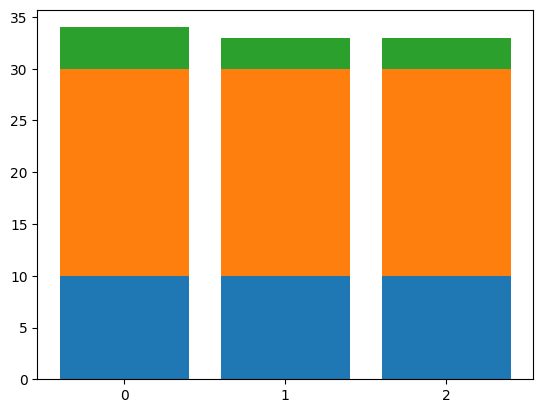

In [10]:
from e2ml.evaluation import cross_validation
# Generate articial class labels.
y = np.zeros(100)
sample_indices = np.arange(len(y), dtype=int)
y[30:90] = 1
y[90:] = 2

# Visualize standard (k=3)-fold cross validation via a bar plot showing the
# class distribution within each fold.
train, test = cross_validation(sample_indices=sample_indices, n_folds=3, random_state=0)

class_disstribution = []
for i, class_y in enumerate(np.unique(y)):
    y_values = []
    for t in test:
        y_values.append(np.sum(y[t] == class_y))
    class_disstribution.append(y_values)
    plt.bar(np.arange(len(test)), y_values, bottom=np.sum(np.array(class_disstribution)[:i], axis=0))
    plt.xticks([0,1,2])

plt.show()

# Visualize stratified (k=3)-fold cross validation via a bar plot showing the class
# distribution within each fold.
train, test = cross_validation(sample_indices=sample_indices, n_folds=3, random_state=0, y=y)

class_disstribution = []
for i, class_y in enumerate(np.unique(y)):
    y_values = []
    for t in test:
        y_values.append(np.sum(y[t] == class_y))
    class_disstribution.append(y_values)
    plt.bar(np.arange(len(test)), y_values, bottom=np.sum(np.array(class_disstribution)[:i], axis=0))
    plt.xticks([0,1,2])

plt.show()


### **2. Model Selection** <a class="anchor" id="model-selection"></a>

In the follwing, we perform a small evaluation study including a model selection. Our goal is to compare the learning algorithm of a [*support vector classifier*](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) (SVC) and a [*multi-layer perceptron*](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) (MLP) on the data set [*breast cancer*](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer). We generate in each run 20 hyperparameter configurations according to one of the popular experimentation methods. Studied hyperparamters are the regularization parameter $C \in (0, 1000)$ (`C`) and the so-called bandwidth $\gamma \in (0, 1]$ (`gamma`) for the SVC, while the learning rate $\eta \in (0, 1]$ (`learning_rate_init`) and another regularization parameter $\alpha \in (0, 1)$ (`alpha`) are studied for the MLP. Further, we use a nested stratified $k=5$-folded cross-valdiation as error-estimation approach. The zero-one loss serves as performance measure to report the emprical mean and standard deviation of the risk estimates.

In [14]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_breast_cancer

# Load breast cancer data set.
X, y = load_breast_cancer(return_X_y=True)

# Perform evaluation study.

# Imports
from e2ml.experimentation import halton
from e2ml.preprocessing import StandardScaler
from e2ml.evaluation import zero_one_loss

# Define parameters
C_upper = 1000
C_lower = 0
gamma_upper = 1
gamma_lower = 0
lr_upper = 1
lr_lower = 0
alpha_upper = 1
alpha_lower = 0

# Hyperparamter configurations (doe method)
theta_svc_list = halton(n_samples=20, n_dimensions=2, bounds=[(C_lower, C_upper), (gamma_lower, gamma_upper)])
theta_mlp_list = halton(n_samples=20, n_dimensions=2, bounds=[(lr_lower, lr_upper), (alpha_lower, alpha_upper)])

# Init helper variables
risks_svc_outer, risks_mlp_outer = [], []

# Cross-Validation
n_folds = 5
sample_indices = np.arange(len(y), dtype=int)
train_outer, test_outer = cross_validation(
    sample_indices=sample_indices,
    n_folds=n_folds,
    y=y,
    random_state=0
)

# Outer k-fold loop, result: test and 'rest' set
for tr_outer, te_outer in zip(train_outer, test_outer):
    # cross_validation
    train_inner, validation_inner = cross_validation(
        sample_indices=tr_outer,
        n_folds=n_folds,
        y=y[tr_outer],
        random_state=0
    )

    # Initial best hyperparameters and risk estimates
    theta_star_svc, theta_star_mlp = None, None
    minimum_risk_svc, minimum_risk_mlp = 1, 1

    # Hyperparameter loop
    for theta_svc, theta_mlp in zip(theta_svc_list, theta_mlp_list):
        risks_svc_inner, risks_mlp_inner = [], []

        # Inner k-fold loop, result: val and train set
        for tr_inner, val_inner in zip(train_inner, validation_inner):
            # Data preprocessing
            sc_inner = StandardScaler()
            sc_inner.fit(X[tr_inner])
            X_tr_inner = sc_inner.transform(X[tr_inner])
            X_val_inner = sc_inner.transform(X[val_inner])

            # Init classifier
            svc_inner = SVC(
                C=theta_svc[0],
                gamma=theta_svc[1],
                random_state=0
            )
            svc_inner.fit(X_tr_inner, y[tr_inner])

            mlp_inner = MLPClassifier(
                learning_rate_init=theta_mlp[0],
                alpha=theta_mlp[1],
                random_state=0
            )
            mlp_inner.fit(X_tr_inner, y[tr_inner])  

            # Evaluate classifier (on val set)
            y_pred_svc = svc_inner.predict(X_val_inner)
            risks_svc_inner.append(zero_one_loss(y_pred=y_pred_svc, y_true=y[val_inner]))

            y_pred_mlp = mlp_inner.predict(X_val_inner)
            risks_mlp_inner.append(zero_one_loss(y_pred=y_pred_mlp, y_true=y[val_inner]))
        
        # Update hyperparameter configs
        if np.mean(risks_svc_inner) <= minimum_risk_svc:
            theta_star_svc = theta_svc
            minimum_risk_svc = np.mean(risks_svc_inner)

        if np.mean(risks_mlp_inner) <= minimum_risk_mlp:
            theta_star_mlp = theta_mlp
            minimum_risk_mlp = np.mean(risks_mlp_inner)


    # Data preprocessing
    sc_outer = StandardScaler()
    sc_outer.fit(X[tr_outer])
    X_tr_outer = sc_outer.transform(X[tr_outer])
    X_te_outer = sc_outer.transform(X[te_outer])

    # Fit classifier (on train + val set)
    svc_outer = SVC(
        C=theta_star_svc[0],
        gamma=theta_star_svc[1],
        random_state=0
    )
    svc_outer.fit(X_tr_outer, y[tr_outer])

    mlp_outer = MLPClassifier(
        learning_rate_init=theta_star_mlp[0],
        alpha=theta_star_mlp[1],
        random_state=0
    )
    mlp_outer.fit(X_tr_outer, y[tr_outer])

    # Evaluate classifier (on test set (te_outer))
    y_pred_svc = svc_outer.predict(X_te_outer)
    risks_svc_outer.append(zero_one_loss(y_pred=y_pred_svc, y_true=y[te_outer]))

    y_pred_mlp = mlp_outer.predict(X_te_outer)
    risks_mlp_outer.append(zero_one_loss(y_pred=y_pred_mlp, y_true=y[te_outer]))

print(f'SVC Performance: {np.mean(risks_svc_outer)} +- {np.std(risks_svc_outer)}')
print(f'MLP Performance: {np.mean(risks_mlp_outer)} +- {np.std(risks_mlp_outer)}')

SVC Performance: 0.04044403043005744 +- 0.00907454171334114
MLP Performance: 0.02462350566682192 +- 0.008671316122652348
